In [1]:
from pymongo  import MongoClient
from wordcloud import WordCloud
import pandas as pd
import re
import collections
from pathlib import Path
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes, preprocessing, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sofia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Connexion à la bdd

In [2]:
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC"]
collection = db["avis"]

In [3]:
df = pd.DataFrame(list(collection.find()))

### Repartition des notes

In [4]:
def repartition_note(df):
    df['note'].hist()
    plt.title('Répartition des notes')
    plt.xticks([1,2,3,4,5, 6, 7, 8, 9, 10])
    plt.show()

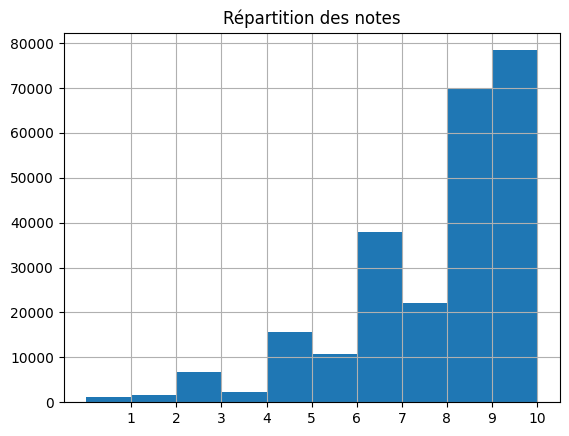

In [5]:
repartition_note(df)

In [19]:
median = df['note'].median()
mean = df['note'].mean()
variance = df['note'].var()
std = df['note'].std()
print("mediane : ", median)
print("moyenne : ", mean)
print("variance : ", variance)
print("ecart-type : ", std)

mediane :  8.0
moyenne :  7.593070451558469
variance :  4.519406433689341
ecart-type :  2.1258895629099226


In [23]:
details = db["details"]
df_details = pd.DataFrame(list(details.find()))

### Jeux les mieux notés

In [40]:
df_details.sort_values(by='Note', ascending=False, inplace=True)
df_details[['titre', 'Note']]

titre  Note
15334                                  Enemy Chocolatier  10.0
13077                                           All-Zeit  10.0
12810                                          Trafalgar  10.0
14088               Star Wars TCG : la Bataille de Yavin  10.0
10686                         Combat Commander : Pacific  10.0
...                                                  ...   ...
7119        Star Wars : Assaut sur l'Empire : Kayn Somos   0.0
6440             Magic l'assemblée : Théros Pack d'intro   0.0
6398                                  Cuboro Tricky Ways   0.0
12074  Axis & Allies Naval Miniatures - War At Sea - ...   0.0
13460                                    Le Spectre Noir   0.0

[20234 rows x 2 columns]

In [41]:
tmp_df = pd.DataFrame()
titres = list(df_details.titre)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = titres[((i-1)*10) : i*10]
tmp_df

1 - 10  \
0                                 Enemy Chocolatier   
1                                          All-Zeit   
2                                         Trafalgar   
3              Star Wars TCG : la Bataille de Yavin   
4                        Combat Commander : Pacific   
5                    Space Alert : The New Frontier   
6        Android : Netrunner - Creation and Control   
7                                           Par : 5   
8                Carcassonne : La Route Commerciale   
9  L'Œil Noir - Dans les Griffes du Démon (Schmidt)   

                                             11 - 20  \
0                              Airborne In my Pocket   
1               L'Œil Noir - L'Archipel des Cyclopes   
2                              Prophecy 2eme edition   
3               L'Œil Noir - Le Bourreau de Thalussa   
4                                        Sugar Cubes   
5                 Corunea : Brute Force Extra-Pack 1   
6                                   Frag Death Match   
7  Advanced Tobruk - Tank Battles in North Africa...   
8                      Revolver: Death Rides a Horse   
9                                      シェフィ - Shephy   

                                             21 - 30  \
0                                              TZAAR   
1                                         The League   
2                                        Banana Jump   
3                 Mémoire 44 : le désastre de Dieppe   
4         Android : Netrunner - Creation and Control   
5                                         Abracadamo   
6  Donjon de Naheulbeuk - Le Grand Bestiaire (Ver...   
7                   Le Val : le testament de Sinnlos   
8                                    LA QUETE D'OLAN   
9         Chronicards : Les chefs-d'oeuvre du Louvre   

                                          31 - 40  \
0  Star Wars Miniatures : Bounty Hunter - Booster   
1          Camouflage : North Pole - Booster pack   
2                      Anno 1701: Das Kartenspiel   
3                                          Fzzzt!   
4                           ARGH : Cartes Goodies   
5         Wonders Duel - Jeton conflit métallique   
6                                  Tarot Lanfeust   
7                                     L'Oeil Noir   
8                          Emmerlaüs : Compagnons   
9                                        Big Boss   

                                 41 - 50  \
0           Mythic Battles - Extension I   
1                     Billard Finlandais   
2                              Diaballik   
3                                 Dégage   
4                          Pierô Artbook   
5                        Quizzard junior   
6        Kipoud : la pioche ou la raison   
7              AT-43 Army Box : Red Blok   
8                  ARGH : Cartes Goodies   
9  Magic l'assemblée : l'Héritage d'Urza   

                                             51 - 60  \
0                                  Larcin Sac de dés   
1                                      Target Arnhem   
2                                Stronghold : Undead   
3                         Stronghold  second edition   
4                                           Pirates!   
5                                             Thalie   
6                                            Scalino   
7  L'Œil Noir - Règles Avancées - Maîtres d'Armes II   
8             Magic l'Assemblée : Avacyn Ressuscitée   
9                         Days of Steam: Locomotives   

                                        61 - 70  \
0  Battles of Napoleon : The Eagle and the Lion   
1  Le Trône de Fer - Une danse avec les dragons   
2                  Viva il Re ! - Les toilettes   
3                                Minotaur Lords   
4                  Mythic Battles - Extension I   
5          Dreamblade Miniatures : Booster pack   
6                                     Ka-ching!   
7                                  Stoner Fluxx   
8  Close Action : The Age of the Fighting Sails   
9        

### Jeux avec le plus d'avis

In [43]:
df_details.sort_values(by='Nombre d\'avis', ascending=False, inplace=True)
df_details[['titre', 'Nombre d\'avis']]

titre  Nombre d'avis
4213                      Citadelles : quatrième édition         1452.0
3121                      Citadelles : quatrième édition         1452.0
5354                                         Carcassonne         1263.0
697                                          Carcassonne         1263.0
7921                                         Small World         1251.0
...                                                  ...            ...
7115   Star Wars : Assaut sur l'Empire : Blasters à l...            0.0
6438                          Magic l'assemblée : Théros            0.0
19805                                               Jena            0.0
7113                                            Abatello            0.0
13460                                    Le Spectre Noir            0.0

[20234 rows x 2 columns]

In [44]:
tmp_df = pd.DataFrame()
titres = list(df_details.titre)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = titres[((i-1)*10) : i*10]
tmp_df

1 - 10            11 - 20  \
0  Citadelles : quatrième édition     7 Wonders Duel   
1  Citadelles : quatrième édition       Jungle Speed   
2                     Carcassonne       Jungle Speed   
3                     Carcassonne           Agricola   
4                     Small World           Agricola   
5         Les Aventuriers du Rail              Dixit   
6                           Catan              Dixit   
7                           Catan      6 qui prend !   
8                        Pandémie  Mr. Jack - London   
9                  7 Wonders Duel          Mysterium   

                            21 - 30              31 - 40  \
0                         Mysterium             Munchkin   
1                             Bang!             Saboteur   
2                          Splendor               Elixir   
3                          Splendor             Dominion   
4                            Caylus             Dominion   
5                          Takenoko  Race for the Galaxy   
6                       Time's Up !      L'Âge de Pierre   
7  Les Chevaliers de la Table Ronde        King of Tokyo   
8                           Jamaïca        King of Tokyo   
9             La Guerre des Moutons         Colt Express   

                      41 - 50                      51 - 60  \
0                Colt Express                        Skull   
1                    Bohnanza           Tigris & Euphrates   
2                       Abyss           Tigris & Euphrates   
3                       Abyss                    Formula D   
4             Schotten-Totten  Lost Cities - The Boardgame   
5             Schotten-Totten                       Hanabi   
6  Dungeon Twister 2 - Prison                       Hanabi   
7                     Camelot              Mr. Jack Pocket   
8                     Camelot                       Myrmes   
9                       Skull                     Cyclades   

                                             61 - 70            71 - 80  \
0                                      Ghost Stories  Terraforming Mars   
1  Sherlock Holmes Détective Conseil : les meurtr...       Gang Of Four   
2  Sherlock Holmes Détective Conseil : les meurtr...            Concept   
3                                         Uno Deluxe            Concept   
4                                        Five Tribes  Service Compris !   
5                                        Five Tribes  Service Compris !   
6                                     Lords of Xidit         The Island   
7                                     Lords of Xidit             Troyes   
8                                            Seasons          Zombicide   
9                                  Terraforming Mars         Mémoire 44   

                      81 - 90                             91 - 100  
0  Ca$h'n Guns second édition                    Il était une fois  
1  Ca$h'n Guns second édition                    Il était une fois  
2                      Taluva                           Can't Stop  
3             L'Île interdite                      T.I.M.E Stories  
4                      Taluva                              Fantasy  
5                   Dice Town                      T.I.M.E Stories  
6                   Dice Town  Mille Bornes - Fun & Speed - Voyage  
7                      Échecs  Mille Bornes - Fun & Speed - Voyage  
8       Las Leyendas de Andor                La Crique des Pirates  
9       Las Leyendas de Andor                             Augustus

### Vocabulaire

In [6]:
df = df.copy()
df['comment'] = df['comment'].astype(str)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.comment)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))

Taille initiale du vocabulaire : 140837


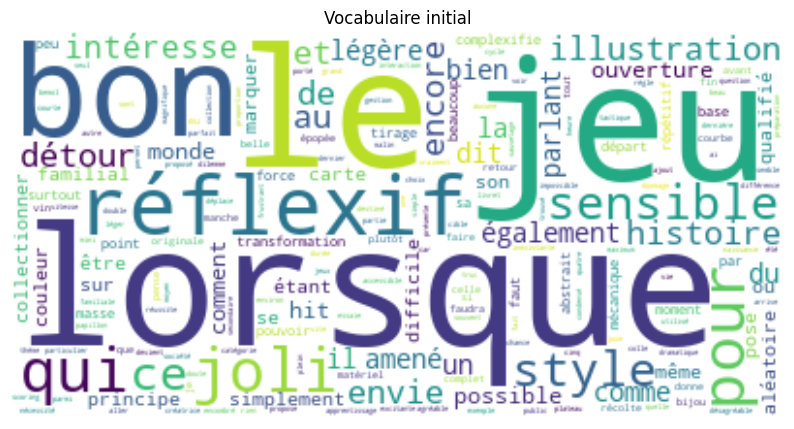

In [10]:
wc = WordCloud(background_color="white").generate(' '.join(vectorizer.vocabulary_.keys()))
plt.figure(figsize=(10, 8))
plt.title('Vocabulaire initial')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
wc = WordCloud().generate(' '.join(df.comment))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

MemoryError: 

### 100 mots les plus frequents

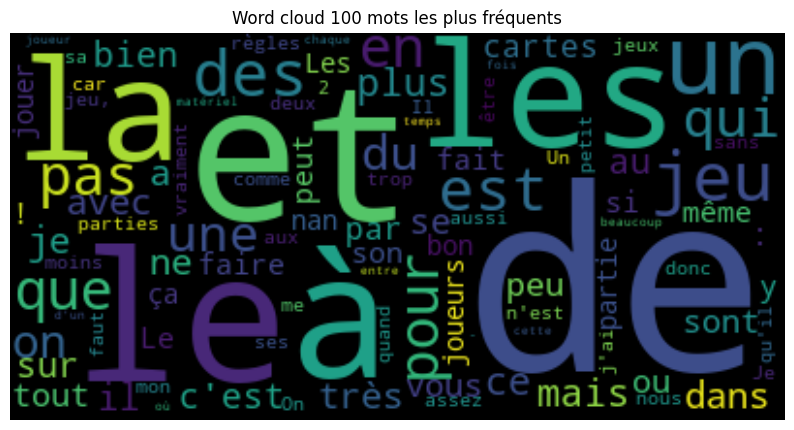

In [7]:
words = " ".join(df.comment).split()
word_counter = Counter(words)

top_100_words = dict(word_counter.most_common(100))

wc = WordCloud().generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 mots les plus fréquents')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [8]:
tmp_df = pd.DataFrame()
top_100_words = list(top_100_words)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = top_100_words[((i-1)*10) : i*10]
tmp_df

1 - 10 11 - 20 21 - 30 31 - 40 41 - 50  51 - 60   61 - 70 71 - 80   81 - 90  \
0     de     pas    mais      se     par      bon      trop   assez     moins   
1     et    pour      ne   c'est    même  joueurs       aux   n'est        sa   
2     le      en    dans     sur    fait   partie      faut      Il        Je   
3      à     que    avec    sont      si       ça  vraiment     car        On   
4    les     qui       a    tout       !    jouer     comme   quand      nous   
5     la     une      je      ou    peut      nan        Un   petit      deux   
6     un      du    très       :       y      Les    règles   aussi      j'ai   
7    jeu      on      il    vous     son  parties        me    donc       mon   
8    des    plus      au     peu      Le     jeux      être   qu'il      jeu,   
9    est      ce    bien  cartes   faire     sans       ses       2  beaucoup   

   91 - 100  
0     cette  
1         -  
2      d'un  
3    chaque  
4        où  
5  matériel  
6     temps  
7    joueur  
8     entre  
9      fois

### Bigramme

In [9]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(df.comment)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

bigram  frequency
0        le jeu      92330
1        un jeu      87181
2         de la      72574
3        ce jeu      62595
4        un peu      58389
..          ...        ...
95       qui ne      10910
96     les jeux      10781
97    je trouve      10729
98  beaucoup de      10710
99   le plateau      10695

[100 rows x 2 columns]

In [10]:
tmp_df = pd.DataFrame()
bigrams = list(top_100_bigrams_df.bigram)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

1 - 10   11 - 20     21 - 30      31 - 40      41 - 50     51 - 60  \
0   le jeu    de jeu       je ne     avec des        de ce     avec un   
1   un jeu     qu il  les règles       que le      jeu qui      pas de   
2    de la   il faut  des cartes      que les      plus de     pour le   
3   ce jeu    il est  les cartes     est très  les parties      on est   
4   un peu    ce qui     on peut    de cartes    peut être    dans les   
5   jeu de     et de     dans la       un bon   les autres      sur la   
6   est un   dans le       et le      bon jeu        on se       si on   
7  jeu est     qu on      sur le        on ne       que on     si vous   
8   du jeu  pour les   la partie      qui est        et on  une partie   
9  est pas    et les      que je  les joueurs        et la   petit jeu   

       61 - 70   71 - 80    81 - 90     91 - 100  
0       ne pas   jeux de   une fois      est une  
1  le matériel   le plus     et est   quand même  
2       peu de   même si     ce que   des règles  
3        je ai   de plus    pour un       jeu et  
4     le thème   en plus     et des      je suis  
5      tout le  très bon   le monde       qui ne  
6     avec les  de jouer   pour moi     les jeux  
7     un petit   de base  très bien    je trouve  
8      sur les  est bien     est le  beaucoup de  
9     tous les    ce est  nombre de   le plateau

### Trigramme

In [14]:
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(df.comment)

trigram_frequencies = np.array(X.sum(axis=0))[0]
trigram_frequencies_sorted = (-trigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_trigrams_df = pd.DataFrame()
top_100_trigrams_df['trigram'] = [features[i] for i in trigram_frequencies_sorted[:100]]
top_100_trigrams_df['frequency'] = [trigram_frequencies[i] for i in trigram_frequencies_sorted[:100]]
top_100_trigrams_df

KeyboardInterrupt: 

In [12]:
tmp_df = pd.DataFrame()
trigrams = list(top_100_trigrams_df.trigram)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = trigrams[((i-1)*10) : i*10]
tmp_df

NameError: name 'top_100_trigrams_df' is not defined

### stopwords

In [8]:
stops_words_french = stopwords.words('french')
others_stops_words = ["a", "as", "ai", "au", "aux", "avec", "ce", "ces", "dans", "de", "des",
                      "du", "elle", "en", "et", "eux", "il", "je", "la", "le", "leur", "lui", 
                      "ma", "mais", "me", "même", "mes", "moi", "mon", "ne", "nos", "notre", 
                      "nous", "on", "ou", "par", "pas", "pour", "qu", "que", "qui", "sa", "se", 
                      "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu", "un", "une", 
                      "vos", "votre", "vous", "c", "d", "j", "l", "à", "m", "n", "s", "t", "y", 
                      "été", "étée", "étées", "étés", "étant", "suis", "es", "est", "sommes", "êtes", 
                      "sont", "serai", "seras", "sera", "serons", "serez", "seront", "serais", "serait", 
                      "serions", "seriez", "seraient", "étais", "était", "étions", "étiez", 
                      "étaient", "fus", "fut", "fûmes", "fûtes", "furent", "sois", "soit", 
                      "soyons", "soyez", "soient", "fusse", "fusses", "fût", "fussions", 
                      "fussiez", "fussent", "ayant", "eu", "eue", "eues", "eus", "ai", "as", 
                      "avons", "avez", "ont", "aurai", "auras", "aura", "aurons", "aurez", 
                      "auront", "aurais", "aurait", "aurions", "auriez", "auraient", "avais", 
                      "avait", "avions", "aviez", "avaient", "eut", "eûmes", "eûtes", "eurent", 
                      "aie", "aies", "ait", "ayons", "ayez", "aient", "eusse", "eusses", "eût", 
                      "eussions", "eussiez", "eussent",
                      #
                      "comme", "comment", "cependant", "parce", "dont", "aussi", "cette",
                      "aujourd", "hui", "dont", "ceci", "cela", "celle", "celui", "ceux", "celles",
                      "pourquoi", "quand", "tout", "toute", "tous", "toutes"]
stops_words_french = sorted( list( set(stops_words_french + others_stops_words) ) )
len(stops_words_french)

179

In [9]:
def delete_stop_word(doc, stop_words=stops_words_french):
    doc = re.sub(r'[\W_]+', ' ', doc)
    return ' '.join([word for word in doc.split() if word.lower() not in stop_words])

In [10]:
corpus = df.comment.map(delete_stop_word)

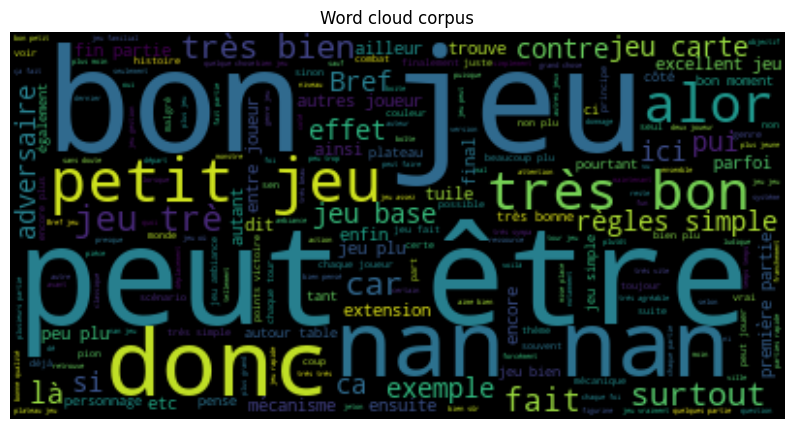

In [11]:
wc = WordCloud().generate(' '.join(corpus))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

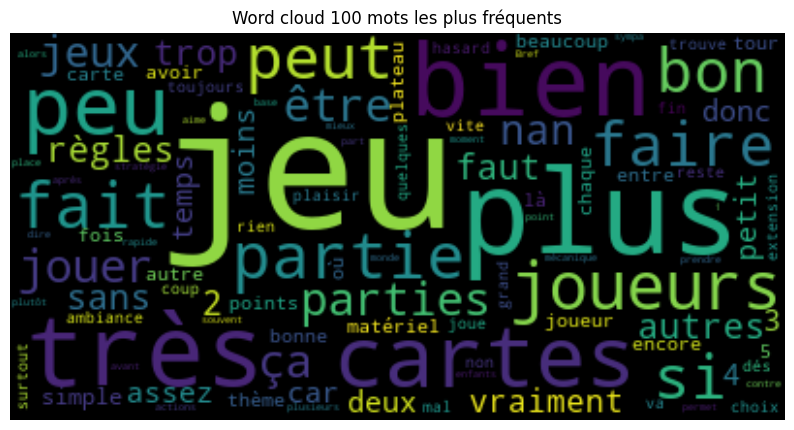

In [12]:
words = " ".join(corpus).split()
word_counter = Counter(words)

top_100_words = dict(word_counter.most_common(100))

wc = WordCloud().generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 mots les plus fréquents')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
tmp_df = pd.DataFrame()
top_100_words = list(top_100_words)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = top_100_words[((i-1)*10) : i*10]
tmp_df

1 - 10 11 - 20   21 - 30   31 - 40   41 - 50    51 - 60    61 - 70  \
0      jeu    peut  vraiment    simple     petit         là       coup   
1     plus      si         2    chaque     moins      assez      grand   
2     très   jouer      sans      trop   plaisir      thème   ambiance   
3     bien   faire    autres         4       nan      bonne  stratégie   
4   cartes    jeux      deux     avoir     entre  extension       base   
5  joueurs     bon       car     temps        où      choix   quelques   
6   partie    être      fois  matériel   plateau      carte       aime   
7     fait      ça         5  beaucoup  toujours      autre      monde   
8      peu  règles      donc    encore      tour       joue       vite   
9  parties    faut         3    joueur    points         va       Bref   

     71 - 80    81 - 90   91 - 100  
0       dire       déjà      alors  
1    surtout    qualité   première  
2      après  mécanique  plusieurs  
3     hasard        dés          1  
4     permet      place     rapide  
5  excellent     moment     trouve  
6        non    système      avant  
7        fin       vrai    simples  
8       rien       seul      mieux  
9    actions    prendre      reste

### odds ratio

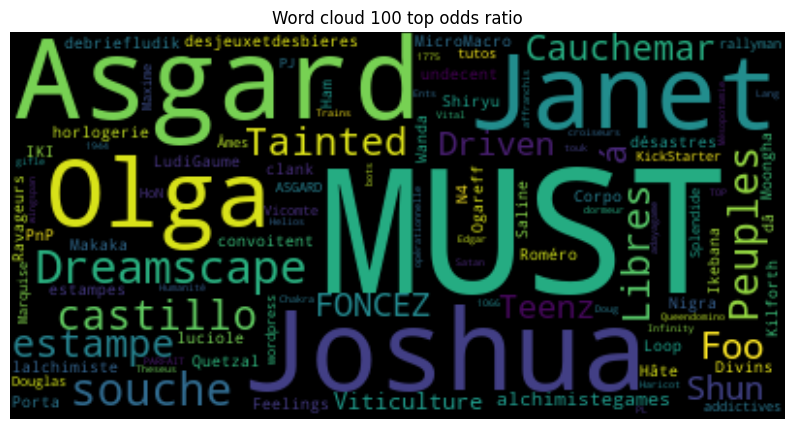

In [21]:
corpus_notes_positives = corpus[df.note >= mean]
corpus_notes_negatives = corpus[df.note < mean]

class1_words = ' '.join(corpus_notes_positives).split()
class2_words = ' '.join(corpus_notes_negatives).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud().generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

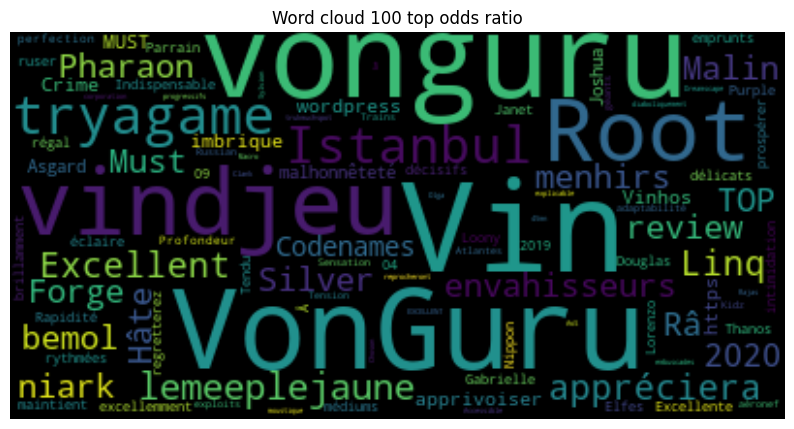

In [22]:
corpus_notes_positives = corpus[df.note >= 5]
corpus_notes_negatives = corpus[df.note < 5]

class1_words = ' '.join(corpus_notes_positives).split()
class2_words = ' '.join(corpus_notes_negatives).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud().generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 100 mots les plus frequents par note

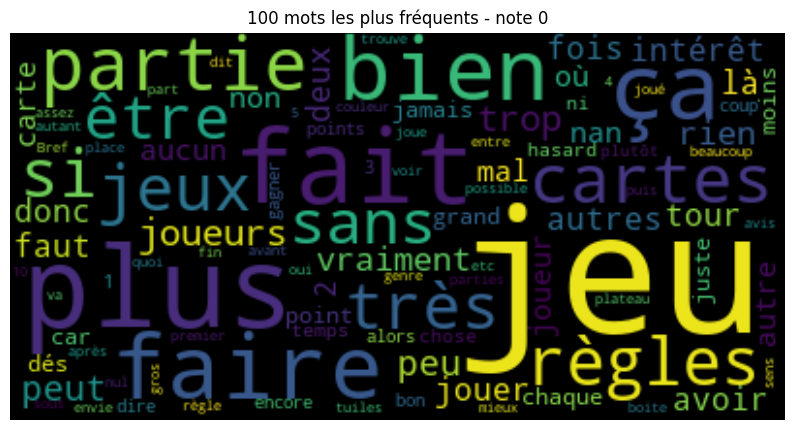

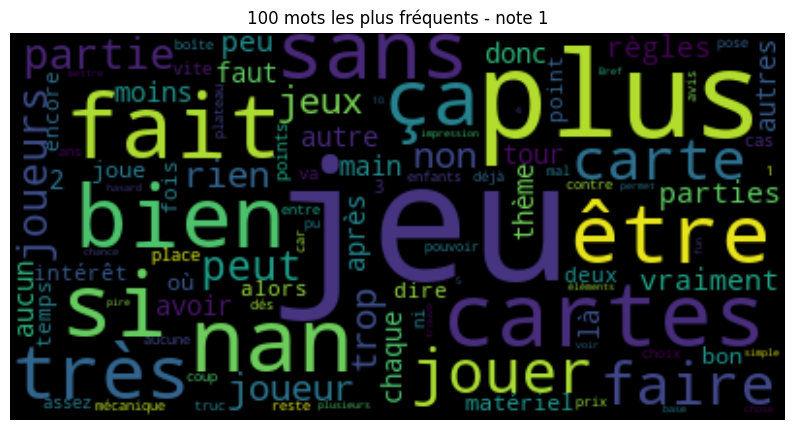

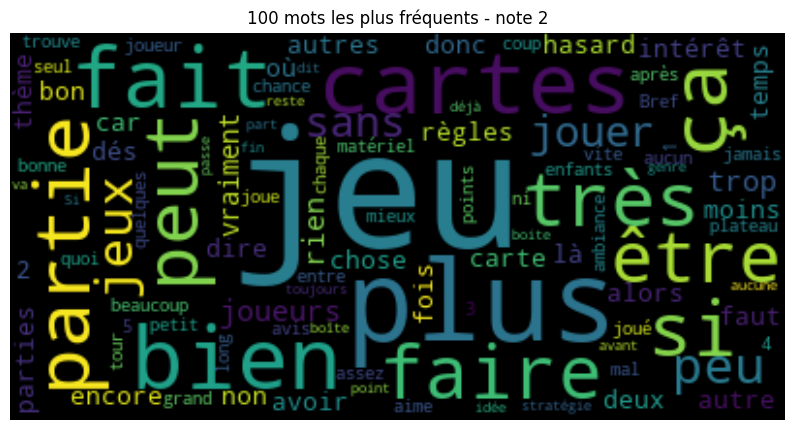

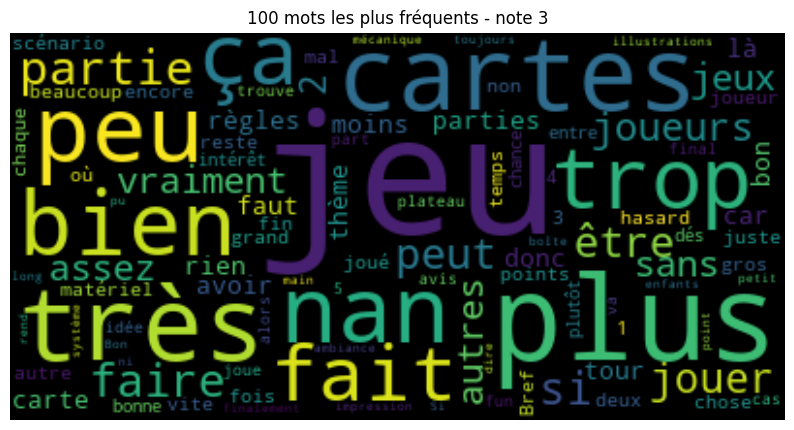

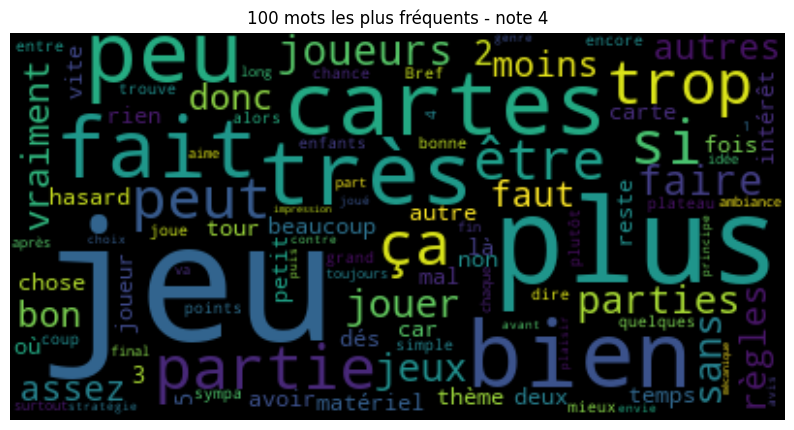

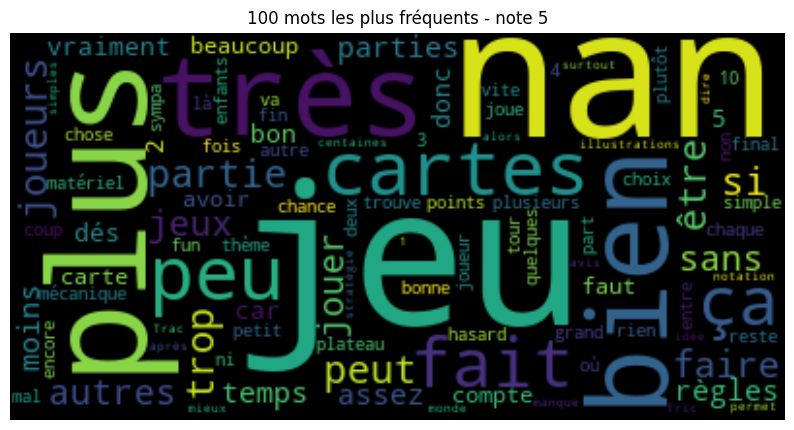

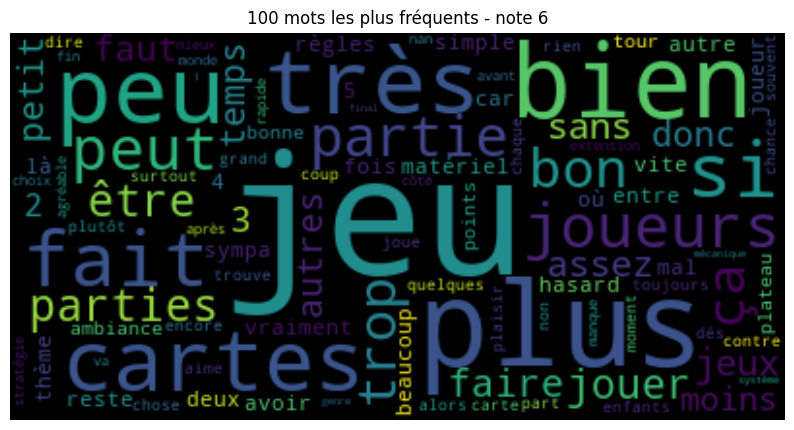

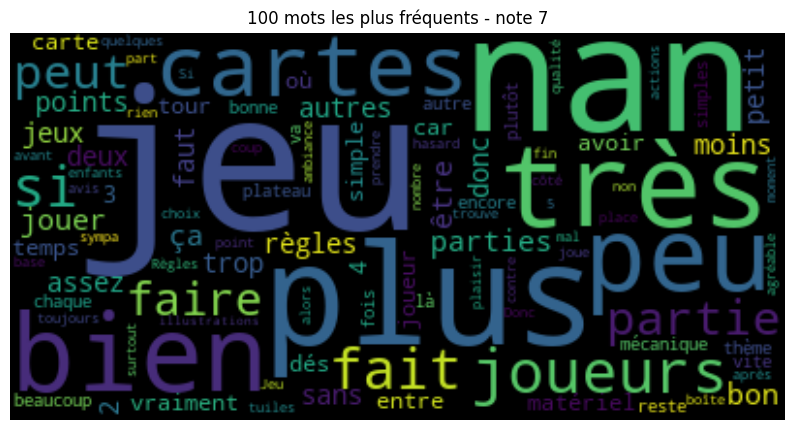

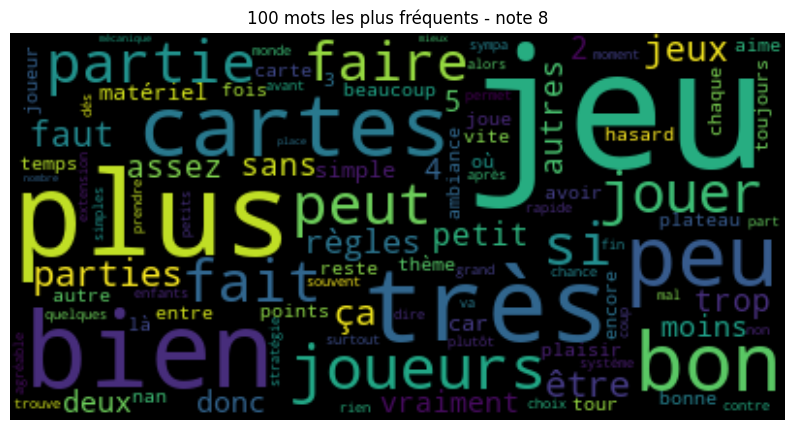

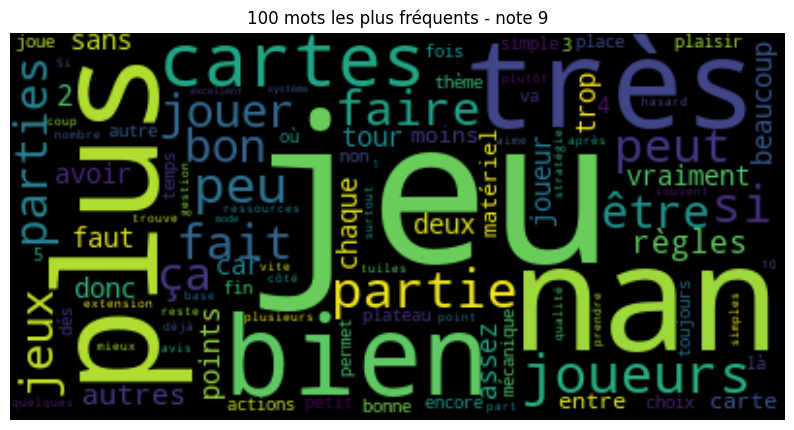

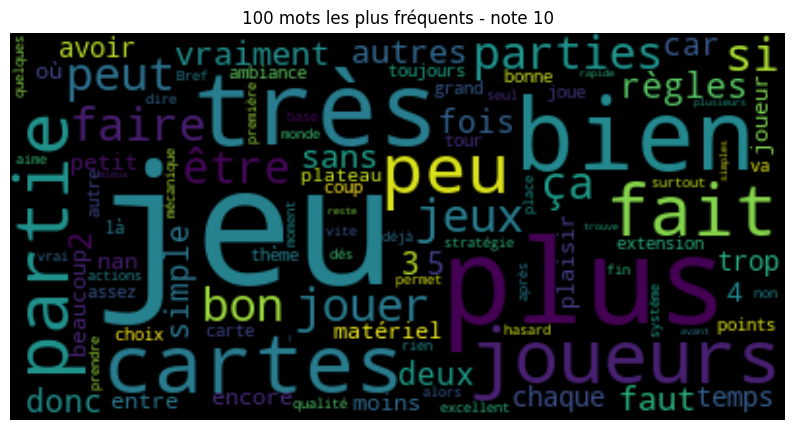

In [26]:
for i in range(0,11):
    corpus_notes = corpus[df.note == i]
    words = " ".join(corpus_notes).split()
    word_counter = Counter(words)

    top_100_words = dict(word_counter.most_common(100))

    wc = WordCloud().generate_from_frequencies(top_100_words)
    plt.figure(figsize=(10, 8))
    plt.title(f'100 mots les plus fréquents - note {i}')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()